# Load candidates

In [1]:
%load_ext autoreload 
%autoreload 2
CACHE = '/home/anhphantq/vdb/cache_train_test'
import os

import pickle
from tqdm import tqdm
train_data = []
num_cands = []

with open(CACHE + '/metadata', 'rb') as f:
  metadata = pickle.load(f)

num_frags = metadata['num_frags']


for i in tqdm(range(num_frags)):
    with open(CACHE + f'/test_train_data_{i}', 'rb') as f:
      data = pickle.load(f)
      train_data.extend(data[0])
      num_cands.extend(data[1])






100%|██████████| 1711/1711 [00:07<00:00, 233.25it/s]


In [2]:
import numpy as np
train_data = np.concatenate(train_data)
num_cands = np.concatenate(num_cands)
train_data.shape, num_cands.shape

((5158157, 39), (5158157,))

In [4]:
from xgb_utils import create_test_data

In [5]:
train_data.shape

(5158157, 39)

In [6]:
import pandas as pd 

candidates = create_test_data(train_data, infer = False)


In [7]:
del train_data

In [8]:
candidates  


,user,item,fiteness,user_clicks,user_carts,user_orders,user_num_sub,user_time_decay,user_lts,user_fts,...,recent_day4_type2,recent_day3_type0,recent_day3_type1,recent_day3_type2,recent_day2_type0,recent_day2_type1,recent_day2_type2,recent_day1_type0,recent_day1_type1,recent_day1_type2
0,11589220.0,938014.0,5.000000,1.0,0.0,0.0,1.0,1.000000,1.000000,1.000000,...,6.0,148.0,24.0,10.0,177.0,45.0,3.0,203.0,50.0,13.0
1,11589220.0,717801.0,2.500000,1.0,0.0,0.0,1.0,0.500000,0.000000,0.000000,...,63.0,1429.0,254.0,77.0,1306.0,272.0,108.0,1263.0,202.0,93.0
2,12258616.0,140045.0,62.000000,18.0,1.0,1.0,1.0,1.000000,1.000000,0.939646,...,1.0,3.0,0.0,0.0,5.0,1.0,1.0,13.0,0.0,0.0
3,12258616.0,1434982.0,34.794141,9.0,1.0,0.0,1.0,0.994118,0.991489,0.990377,...,0.0,57.0,3.0,2.0,57.0,2.0,0.0,75.0,4.0,1.0
4,12258616.0,996948.0,34.572772,11.0,0.0,0.0,1.0,0.987793,0.982281,0.944152,...,2.0,643.0,18.0,1.0,744.0,9.0,2.0,1051.0,14.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5158152,12127086.0,787062.0,5.000000,1.0,0.0,0.0,1.0,1.000000,0.000000,0.000000,...,3.0,136.0,18.0,6.0,139.0,20.0,7.0,121.0,15.0,6.0
5158153,11721878.0,1520126.0,5.500000,1.0,1.0,0.0,1.0,0.500000,0.000000,0.000000,...,0.0,4.0,1.0,0.0,4.0,1.0,1.0,7.0,3.0,1.0
5158154,11721878.0,216509.0,5.000000,1.0,0.0,0.0,1.0,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5158155,11676751.0,577421.0,5.000000,1.0,0.0,0.0,1.0,1.000000,0.000000,0.000000,...,2.0,90.0,11.0,2.0,74.0,6.0,2.0,116.0,16.0,6.0


In [9]:
len(candidates.columns)

39

# Train params

In [10]:
PARAMS = {
    'max_depth' : 5,
    'eta': 1,    
}
N_SPLITS = 3
NUM_TREE = 100
MODEL_PATH = '/home/anhphantq/xgboost_test'
VERSION = '3'

# Train for each type

In [11]:
from xgb_utils import get_len_group

In [12]:
import pandas as pd 
import numpy as np
tar = pd.read_parquet('/home/anhphantq/otto/splitted_data/test_labels.parquet')
tar = tar.loc[(tar['session'] <= candidates['user'].max()) & (tar['session'] >= candidates['user'].min()) ]
aids = tar.ground_truth.explode().astype('int32').rename('item')
tar = tar[['session', 'type']].rename({'session':'user'},axis=1)
tar = tar.merge(aids, left_index=True, right_index=True, how='left')
tar['type'] = tar['type'].apply(lambda x: 0 if x == 'clicks' else 1 if x == 'carts' else 2)
tar['label'] = 1

In [13]:
tar

,user,type,item,label
113400,11188590,0,607328,1
113401,11188591,0,557157,1
113402,11188591,1,1597320,1
113402,11188591,1,1236555,1
113402,11188591,1,970284,1
...,...,...,...,...
2212687,12899774,0,1399483,1
2212688,12899775,0,1760714,1
2212689,12899776,0,1737908,1
2212690,12899777,0,384045,1


In [14]:
candidates

,user,item,fiteness,user_clicks,user_carts,user_orders,user_num_sub,user_time_decay,user_lts,user_fts,...,recent_day4_type2,recent_day3_type0,recent_day3_type1,recent_day3_type2,recent_day2_type0,recent_day2_type1,recent_day2_type2,recent_day1_type0,recent_day1_type1,recent_day1_type2
0,11589220.0,938014.0,5.000000,1.0,0.0,0.0,1.0,1.000000,1.000000,1.000000,...,6.0,148.0,24.0,10.0,177.0,45.0,3.0,203.0,50.0,13.0
1,11589220.0,717801.0,2.500000,1.0,0.0,0.0,1.0,0.500000,0.000000,0.000000,...,63.0,1429.0,254.0,77.0,1306.0,272.0,108.0,1263.0,202.0,93.0
2,12258616.0,140045.0,62.000000,18.0,1.0,1.0,1.0,1.000000,1.000000,0.939646,...,1.0,3.0,0.0,0.0,5.0,1.0,1.0,13.0,0.0,0.0
3,12258616.0,1434982.0,34.794141,9.0,1.0,0.0,1.0,0.994118,0.991489,0.990377,...,0.0,57.0,3.0,2.0,57.0,2.0,0.0,75.0,4.0,1.0
4,12258616.0,996948.0,34.572772,11.0,0.0,0.0,1.0,0.987793,0.982281,0.944152,...,2.0,643.0,18.0,1.0,744.0,9.0,2.0,1051.0,14.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5158152,12127086.0,787062.0,5.000000,1.0,0.0,0.0,1.0,1.000000,0.000000,0.000000,...,3.0,136.0,18.0,6.0,139.0,20.0,7.0,121.0,15.0,6.0
5158153,11721878.0,1520126.0,5.500000,1.0,1.0,0.0,1.0,0.500000,0.000000,0.000000,...,0.0,4.0,1.0,0.0,4.0,1.0,1.0,7.0,3.0,1.0
5158154,11721878.0,216509.0,5.000000,1.0,0.0,0.0,1.0,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5158155,11676751.0,577421.0,5.000000,1.0,0.0,0.0,1.0,1.000000,0.000000,0.000000,...,2.0,90.0,11.0,2.0,74.0,6.0,2.0,116.0,16.0,6.0


In [15]:
import xgboost as xgb
from sklearn.model_selection import GroupKFold
import os
import shutil
def train(tar_, candidates_, t, num_cands, id_type):
  name = f'/{t}_only_'
  try:
    shutil.rmtree(MODEL_PATH + name + VERSION)
  except:
    pass
  else:
    print('remove old version')
  
  tar = tar_[tar_['type'] == id_type].copy()
  candidates = candidates_.copy()
  candidates['type'] = id_type
  
  candidates['user_type'] = candidates['user'] * 10 + candidates['type']
  tar['user_type'] = tar['user'] * 10 + tar['type']
  del tar['type'], tar['user']
  candidates = candidates.merge(tar,on=['user_type','item'],how='left').fillna(0)
  candidates['label'] = candidates['label'].values.astype(np.int16)

  # neg_idx = np.argwhere(candidates['label'].values.flatten() == 0)
  # neg_idx = np.random.permutation(neg_idx)[: int(len(neg_idx) * 0.5)]
  # candidates = candidates.drop(neg_idx.flatten()).reset_index()
  # num_cands = candidates[['user', 'item']].groupby('user').count().reset_index()
  # num_cands['num_cands'] = num_cands['item']
  # del num_cands['item'] 
  # candidates = candidates.merge(num_cands,on=['user'],how='left')
  # num_cands = candidates['num_cands'].values


  print(np.sum(candidates['label']), candidates.shape[0])
  
  del candidates['type'], candidates['user_type']

  skf = GroupKFold(n_splits=N_SPLITS)
  for fold,(train_idx, valid_idx) in enumerate(skf.split(candidates, candidates['label'], groups=candidates['user'] )):

      X_train = candidates.iloc[train_idx, 2 : -1]
      y_train = candidates.iloc[train_idx, -1]
      X_valid = candidates.iloc[valid_idx, 2 : -1]
      y_valid = candidates.iloc[valid_idx, -1]

      dtrain = xgb.DMatrix(X_train, y_train, nthread = os.cpu_count() ) 
      dtrain.set_group(get_len_group(train_idx, num_cands))
      dvalid = xgb.DMatrix(X_valid, y_valid, nthread = os.cpu_count() ) 
      dvalid.set_group(get_len_group(valid_idx, num_cands))
      
      xgb_parms = {'objective':'rank:pairwise', 'nthread' : os.cpu_count(),
      **PARAMS}
      model = xgb.train(xgb_parms, 
          dtrain=dtrain,
          evals=[(dtrain,'train'),(dvalid,'valid')],
          num_boost_round=NUM_TREE,
          verbose_eval=1,
          early_stopping_rounds= 5, )
      try:
        os.mkdir(MODEL_PATH + name + VERSION)
      except:
        pass
      model.save_model(MODEL_PATH + name + VERSION + f'/XGB_fold{fold}.xgb')
      xgb.plot_importance(model)

540517 5158157
[0]	train-map:0.95405	valid-map:0.95398
[1]	train-map:0.95458	valid-map:0.95455
[2]	train-map:0.95480	valid-map:0.95473
[3]	train-map:0.95558	valid-map:0.95548
[4]	train-map:0.95582	valid-map:0.95569
[5]	train-map:0.95598	valid-map:0.95584
[6]	train-map:0.95604	valid-map:0.95590
[7]	train-map:0.95610	valid-map:0.95591
[8]	train-map:0.95629	valid-map:0.95604
[9]	train-map:0.95634	valid-map:0.95605
[10]	train-map:0.95659	valid-map:0.95634
[11]	train-map:0.95663	valid-map:0.95638
[12]	train-map:0.95664	valid-map:0.95636
[13]	train-map:0.95669	valid-map:0.95648
[14]	train-map:0.95679	valid-map:0.95656
[15]	train-map:0.95680	valid-map:0.95654
[16]	train-map:0.95681	valid-map:0.95651
[17]	train-map:0.95684	valid-map:0.95652
[18]	train-map:0.95686	valid-map:0.95654
[19]	train-map:0.95695	valid-map:0.95659
[20]	train-map:0.95705	valid-map:0.95661
[21]	train-map:0.95707	valid-map:0.95662
[22]	train-map:0.95711	valid-map:0.95664
[23]	train-map:0.95713	valid-map:0.95659
[24]	train-

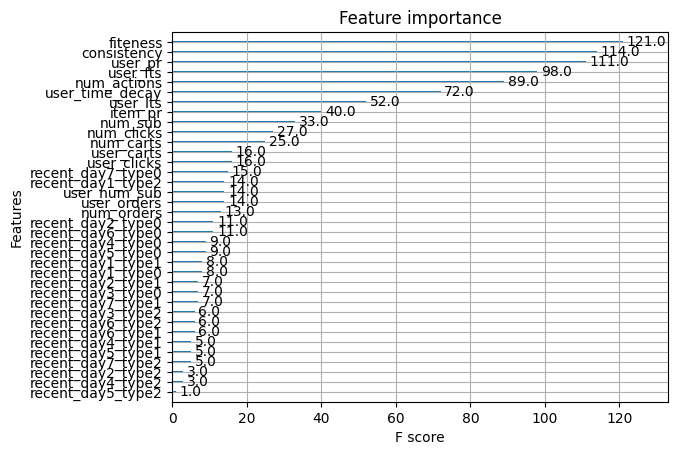

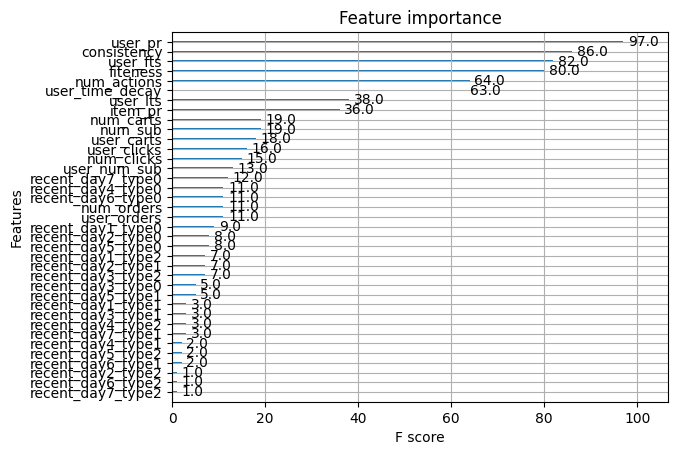

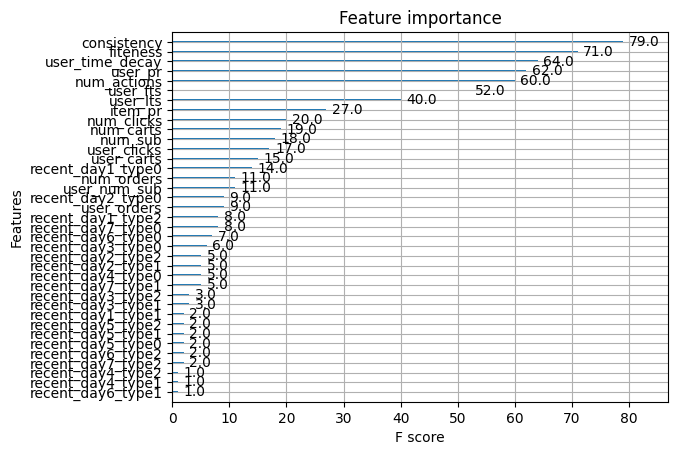

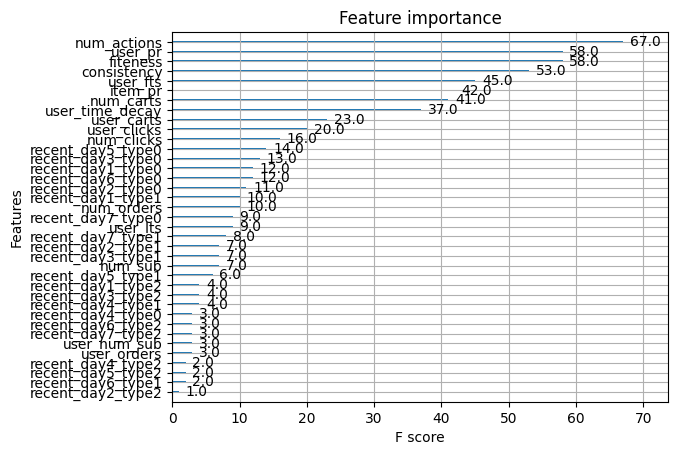

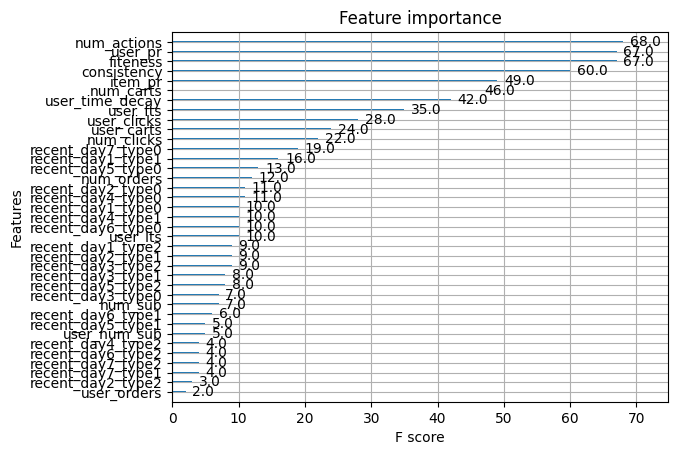

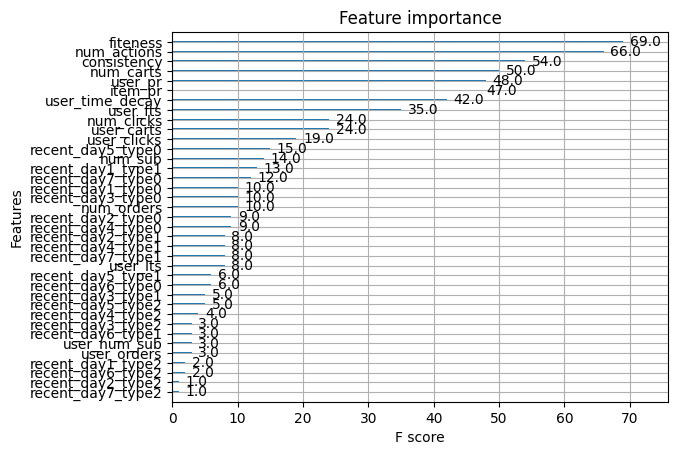

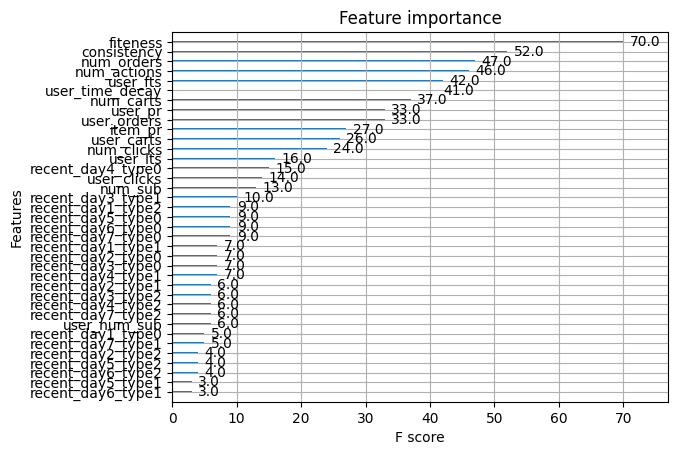

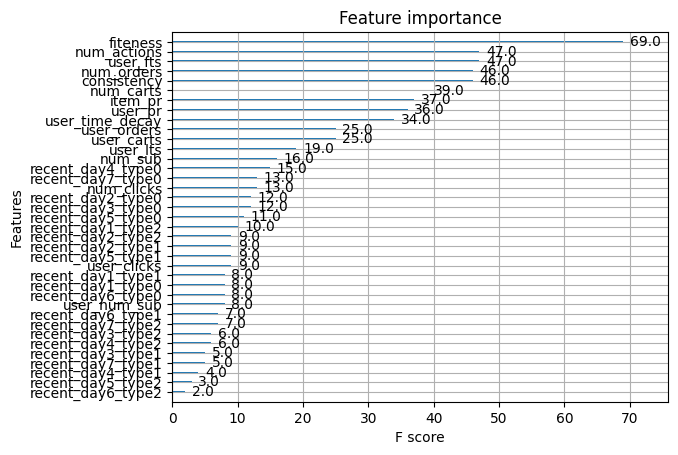

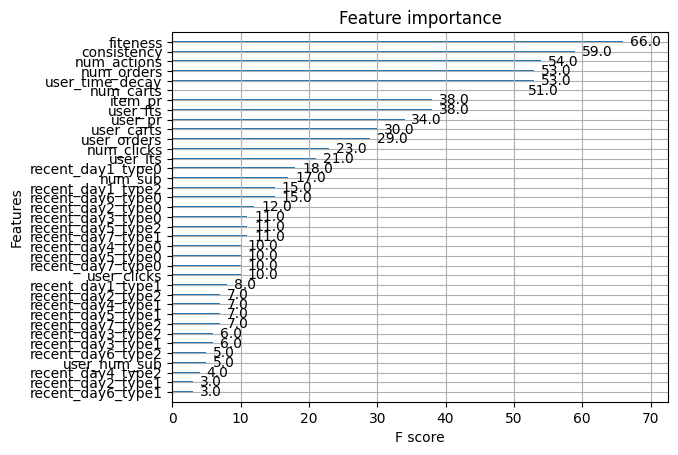

In [16]:
%%time
for id_type, t in enumerate(['clicks', 'carts', 'orders']):
  train(tar, candidates, t, num_cands, id_type)